## Imports 

In [182]:
# Basics
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

# for tokenizing and lemmantizing
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

# for models 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Load Data

In [84]:
reddit_df = pd.read_csv('../data/preprocessed-data.csv')
reddit_df.head()

,subreddit,title,body,created,score,num_comments,id,combined_text,body_length,body_word_count,body_lemmatized,body_stemmed
0,personalfinance,taxes during retirement,i have been searching for this information but...,1.728232e+09,1,2,1fxkhfd,taxes during retirement i have been searching...,712,131,tax during retirement i have been searching fo...,tax dure retir i have been search for thi info...
1,personalfinance,withdraw from 401k help,i have 40k in my 401k i have set my mind on wi...,1.728231e+09,0,4,1fxk5ml,withdraw from 401k help i have 40k in my 401k...,400,88,withdraw from 401k help i have 40k in my 401k ...,withdraw from 401k help i have 40k in my 401k ...
2,personalfinance,16k car silly choice,hello as title says ive been looking around at...,1.728231e+09,1,2,1fxk4qv,16k car silly choice hello as title says ive b...,603,127,16k car silly choice hello a title say ive bee...,16k car silli choic hello as titl say ive been...
3,personalfinance,financial advice on savings,hi folks\n\nso im torn about what i should do ...,1.728231e+09,1,2,1fxk29l,financial advice on savings hi folks\n\nso im ...,733,147,financial advice on saving hi folk so im torn ...,financi advic on save hi folk so im torn about...
4,personalfinance,suggestion for spending on a phone,what do you suggets for this scenario\nmy comp...,1.728230e+09,0,0,1fxjtot,suggestion for spending on a phone what do you...,713,136,suggestion for spending on a phone what do you...,suggest for spend on a phone what do you sugge...


In [85]:
reddit_df.shape

(2638, 12)

In [86]:
reddit_df.isnull().sum()

subreddit           0
title               0
body                0
created            72
score               0
num_comments        0
id                  0
combined_text       0
body_length         0
body_word_count     0
body_lemmatized     0
body_stemmed        0
dtype: int64

In [87]:
# drop rows with no body 
reddit_df.dropna(subset = ['body'], inplace = True)
reddit_df.shape

(2638, 12)

## Text Preprocessing 
> * Create target column 

In [88]:
# Create target column 
reddit_df['target'] = reddit_df['subreddit'].map({'personalfinance': 1, 'investing': 0})
reddit_df.head()

,subreddit,title,body,created,score,num_comments,id,combined_text,body_length,body_word_count,body_lemmatized,body_stemmed,target
0,personalfinance,taxes during retirement,i have been searching for this information but...,1.728232e+09,1,2,1fxkhfd,taxes during retirement i have been searching...,712,131,tax during retirement i have been searching fo...,tax dure retir i have been search for thi info...,1
1,personalfinance,withdraw from 401k help,i have 40k in my 401k i have set my mind on wi...,1.728231e+09,0,4,1fxk5ml,withdraw from 401k help i have 40k in my 401k...,400,88,withdraw from 401k help i have 40k in my 401k ...,withdraw from 401k help i have 40k in my 401k ...,1
2,personalfinance,16k car silly choice,hello as title says ive been looking around at...,1.728231e+09,1,2,1fxk4qv,16k car silly choice hello as title says ive b...,603,127,16k car silly choice hello a title say ive bee...,16k car silli choic hello as titl say ive been...,1
3,personalfinance,financial advice on savings,hi folks\n\nso im torn about what i should do ...,1.728231e+09,1,2,1fxk29l,financial advice on savings hi folks\n\nso im ...,733,147,financial advice on saving hi folk so im torn ...,financi advic on save hi folk so im torn about...,1
4,personalfinance,suggestion for spending on a phone,what do you suggets for this scenario\nmy comp...,1.728230e+09,0,0,1fxjtot,suggestion for spending on a phone what do you...,713,136,suggestion for spending on a phone what do you...,suggest for spend on a phone what do you sugge...,1


In [111]:
# Unique words for each subreddit
unique_investing_words = ['investor', 'resource', 'trading', 'list', 'relevant', 'useful', 'wiki', 'sampp', 'level', 'sector', 'trade', 'allocation', 'daily', 'vti', 'exposure', 'data', 'world', 'discussion', 'international', 'horizon']  
unique_personalfinance_words = ['vehicle', 'owe', 'afford', 'cc', 'deductible', 'auto', 'apr', 'collection', 'policy', 'charge', 'phone', 'claim', 'refinance', 'file', 'repair', 'food', 'asked', 'truck', 'mile', '15k']  

# Combine
unique_words = unique_investing_words + unique_personalfinance_words

In [216]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name): 
    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
    disp.plot(cmap = plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.savefig(f'../images/{model_name}-confusion-matrix.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show

## Train-test split 

In [89]:
X = reddit_df['body_lemmatized']
y = reddit_df['target']

In [90]:
y.value_counts(normalize = True)

target
1    0.59856
0    0.40144
Name: proportion, dtype: float64

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

### Model Selection 
> * **Logistic Regression**: Binary classifcation problems, baseline model
> * **Naive Bayes**
> * Other Possible Models to explore: 
> * Support Vector Machine
> * Random Forests
> * XGBoost 

## Model Training and Evaluation

### Logistic Regression Model, CountVectorizer

> This is my baseline model. Logistic Regression is a simple, interpretable model that acts as a benchmark before diving into more complex models. In this case, the Logistic Regression model performed fairly well with CountVectorizer. This model acheived high accuracy, precision and recall making it a great starting point to compare the rest of our models to.

In [131]:
# Baseline model: Logistic Regression, with CountVectorizer 
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('scaler', StandardScaler(with_mean=False)), 
    ('lr', LogisticRegression(max_iter = 500))
])

In [93]:
# Pipe parameters
pipe_params = {
    'cvec__max_features': [500, 1000, 1500, 2000], 
    'cvec__stop_words': [None, 'english'], 
    'cvec__ngram_range': [(1,1),(1,2)],
    'cvec__lowercase': [True],
    'lr__C': [0.01, 0.1, 1, 10],  
    'lr__penalty': ['l1', 'l2'], 
    'lr__solver': ['liblinear']
}

In [94]:
# Instantiate GridSearchCV.
gs = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5) 

In [95]:
# Fit the model
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('lr',
                                        LogisticRegression(max_iter=500))]),
             param_grid={'cvec__lowercase': [True],
                         'cvec__max_features': [500, 1000, 1500, 2000],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'lr__C': [0.01, 0.1, 1, 10],
                         'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['liblinear']})

In [200]:
# Print model scores
print(f'Best score: {gs.best_score_}')
print()
print(f'Best params: {gs.best_params_}')
print()
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

Best score: 0.8317535545023697

Best params: {'cvec__lowercase': True, 'cvec__max_features': 1500, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       212
           1       0.86      0.89      0.87       316

    accuracy                           0.84       528
   macro avg       0.84      0.83      0.84       528
weighted avg       0.84      0.84      0.84       528



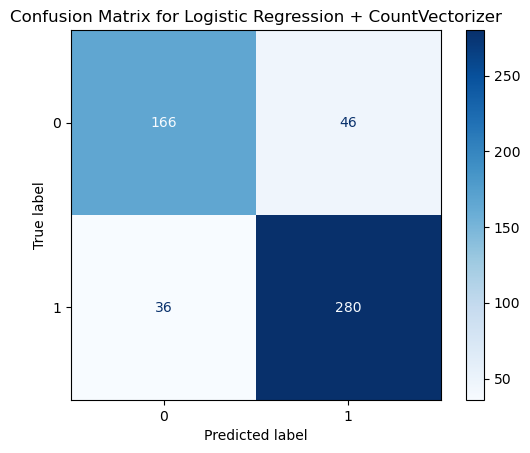

In [203]:
plot_confusion_matrix(y_test, y_pred, 'Logistic Regression + CountVectorizer')

#### Findings 
* **Precision**: 0.86
> * This means that 86% of the times the model predicted r/personalfinance, it was correct. Because precision is high, we can assume that we have low false positives. This means that the model does not incorrectly label too many r/investing posts as r/personalfinance.
* **Recall**: 0.89
> * This means that the model identified 89% of the actual r/personalfinance posts correctly. False negatives are low because recall is high. The model is correctly identifying most of the r/personalfinance posts.
* **F-1 Score**: 0.87
> * This is the balance between precision and recall.
* **Overall Accuracy**: 0.84

### Logistic Regression Model, CountVectorizer with Custom Vocabulary Parameter

> While preprocessing my text data, I noticed that there were several words that were unique to each subreddit. I thought that maybe my model would improve if the vocabulary paramter was hand-picked based on this. I went ahead and fit my Logistic Regression model using a CountVectorizer and my own vocabulary parameter. The custom vocabulary ultimately **did not** improve the model's performance over the baseline model. From this, we can assume that the manually defined vocabulary may not capture meaningful features compared to vocabulary automatically chosen by the vectorizer. There can be several reason for these drawbacks. By limiting the vocabulary, the model may be missing out on other relevant words that may provide nuance. Another drawback to this model may be that it is easier to inject personal bias. This results in essential terms being ignored. Custom vocabulary also poses flexibilty issues. The model may not generalize well across different or updated datasets leading to poor future performance. By hand selecting the vocabulary, the model risks becoming an oversimplified model that may not be able to capture patterns in the data or becoming too specific and overfit. Finally, creating this model manually helped me understand how tedious the process of parsing through data to find key words to add to the vocabulary would be. Despite these drawbacks, the model surprisingly did not perform worse. However, the model's performance did not improve either. This suggests that the manually defined vocabulary parameter may not be able to capture enough nuance to improve the model's performance. 


In [112]:
# Logistic Regression, with CountVectorizer using unique_words for vocabulary parameter
pipe_lr_cvec_vocab = Pipeline([
    ('cvec', CountVectorizer(vocabulary = unique_words)),
    ('scaler', StandardScaler(with_mean=False)), 
    ('lr', LogisticRegression(max_iter = 500))
])

In [113]:
pipe_params_lr_cvec_vocab = {
    'cvec__max_features': [1500], 
    'cvec__stop_words': ['english'], 
    'cvec__ngram_range': [(1,2)],
    'cvec__lowercase': [True],
    'lr__C': [0.01],  
    'lr__penalty': ['l2'], 
    'lr__solver': ['liblinear']
}

In [114]:
# Instantiate GridSearchCV.
gs_lr_cvec_vocab = GridSearchCV(pipe_lr_cvec_vocab, 
                                pipe_params_lr_cvec_vocab, 
                                cv = 5) 

In [115]:
gs_lr_cvec_vocab.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('lr',
                                        LogisticRegression(max_iter=500))]),
             param_grid={'cvec__lowercase': [True],
                         'cvec__max_features': [500, 1000, 1500, 2000],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'lr__C': [0.01, 0.1, 1, 10],
                         'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['liblinear']})

In [204]:
print(f'Best Score: {gs_lr_cvec_vocab.best_score_}')
print()
print(f'Best params: {gs_lr_cvec_vocab.best_params_}')
print()
y_pred = gs_lr_cvec_vocab.predict(X_test)
print(classification_report(y_test, y_pred))

Best Score: 0.8317535545023697

Best params: {'cvec__lowercase': True, 'cvec__max_features': 1500, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       212
           1       0.86      0.89      0.87       316

    accuracy                           0.84       528
   macro avg       0.84      0.83      0.84       528
weighted avg       0.84      0.84      0.84       528



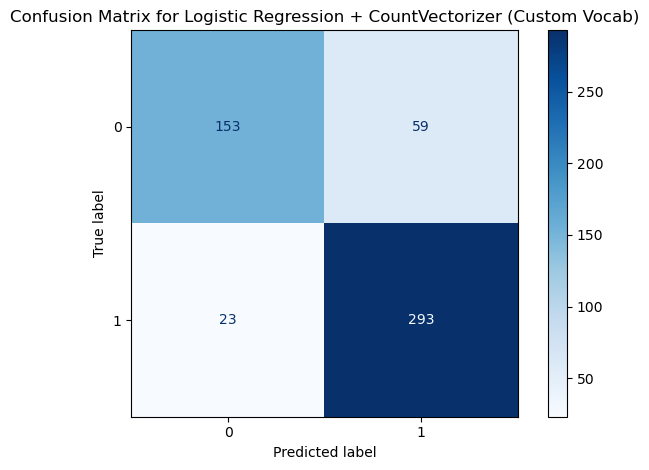

In [217]:
plot_confusion_matrix(y_test, y_pred, 'Logistic Regression + CountVectorizer (Custom Vocab)')

#### Findings 
* **Precision**: 0.86
> * This means that 86% of the times the model predicted r/personalfinance, it was correct. Because precision is high, we can assume that we have low false positives. This means that the model does not incorrectly label too many r/investing posts as r/personalfinance.
* **Recall**: 0.89
> * This means that the model identified 89% of the actual r/personalfinance posts correctly. False negatives are low because recall is high. The model is correctly identifying most of the r/personalfinance posts.
* **F-1 Score**: 0.87
> * This is the balanced score between precision and recall.
* **Overall Accuracy**: 0.84

### Logistic Regression Model, TfidfVectorizer

> TF-IDF Vectorizer puts more emphasis on less frequent, unique terms in documents. This allows the model to better capture the distingushing features of each subreddit. 


In [101]:
# Logistic Regression, with TVEC 
pipe_lr_tvec = Pipeline([
    ('tvec', TfidfVectorizer()), 
    ('lr', LogisticRegression(max_iter = 500))
])

In [102]:
pipe_lr_tvec_params = {
    'tvec__max_features':[2000, 3000, 4000, 5000],
    'tvec__stop_words': [None, 'english'], 
    'tvec__ngram_range': [(1, 1), (1, 2)], 
}

In [103]:
gs_lr_tvec = GridSearchCV(pipe_lr_tvec,
                      param_grid=pipe_lr_tvec_params,
                      cv = 5,
                      verbose = 2, 
                      n_jobs = -1 
                      )

In [104]:
gs_lr_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1,
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=2)

In [206]:
print(f'Best Score: {gs_lr_tvec.best_score_}')
print()
print(f'Best params: {gs_lr_tvec.best_params_}')
print()
y_pred = gs_lr_tvec.predict(X_test)
print(classification_report(y_test, y_pred))

Best Score: 0.8483412322274881

Best params: {'tvec__max_features': 3000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       212
           1       0.86      0.91      0.88       316

    accuracy                           0.85       528
   macro avg       0.85      0.84      0.85       528
weighted avg       0.85      0.85      0.85       528



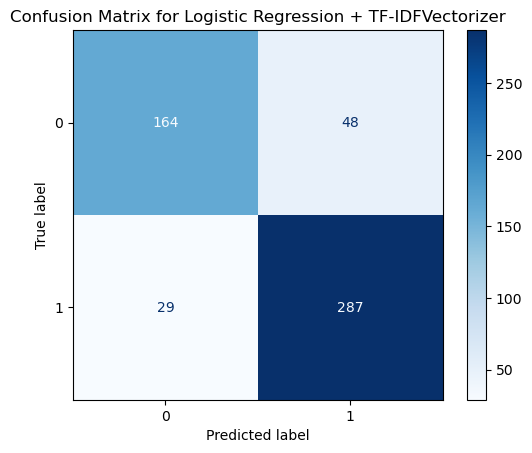

In [207]:
plot_confusion_matrix(y_test, y_pred, 'Logistic Regression + TF-IDFVectorizer')

#### Findings 
* **Precision**: 0.86
> * This means that 86% of the times the model predicted r/personalfinance, it was correct. Because precision is high, we can assume that we have low false positives. This means that the model does not incorrectly label too many r/investing posts as r/personalfinance.
* **Recall**: 0.91 (Higher than CountVectorizer)
> * This means that the model identified 91% of the actual r/personalfinance posts correctly. False negatives are low because recall is high. The model is correctly identifying most of the r/personalfinance posts. One thing to note, the recall for r/investing decreased to 77%. 
* **F-1 Score**: 0.88
> * This is the balance between precision and recall.
* **Overall Accuracy**: 0.85
> * Compared to the baseline model, TfidfVectorizer slightly improves the accuracy from 0.84 to 0.85. This suggests that TF-IDF is capturing more relevant features than the word counts from CountVectorizer. 

### Logistic Regression Model, TfidfVectorizer with Custom Vocabulary Parameter

> As mentioned above, using custom vocabulary has multiple drawbacks. When they are not well-researched or there is not enough data to capture relevant terms effectively, they can harm a model's performance. 


In [122]:
# Logistic Regression, with TVEC and vocab 
pipe_lr_tvec_vocab = Pipeline([
    ('tvec', TfidfVectorizer(vocabulary = unique_words)), 
    ('lr', LogisticRegression(max_iter = 500))
])

In [124]:
pipe_lr_tvec_vocab_params = {
    'tvec__max_features':[2000, 3000, 4000, 5000],
    'tvec__stop_words': [None, 'english'], 
    'tvec__ngram_range': [(1, 1), (1, 2)], 
}

In [138]:
gs_lr_tvec_vocab = GridSearchCV(pipe_lr_tvec_vocab,
                      param_grid=pipe_lr_tvec_vocab_params,
                      cv = 5,
                      verbose = 2, 
                      n_jobs = -1 
                      )

In [139]:
gs_lr_tvec_vocab.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(vocabulary=['investor',
                                                                    'resource',
                                                                    'trading',
                                                                    'list',
                                                                    'relevant',
                                                                    'useful',
                                                                    'wiki',
                                                                    'sampp',
                                                                    'level',
                                                                    'sector',
                                                                    'trade',
                                                                    'allocation',
                                                                    'daily',
                                                                    'vti',
                                                                    'exposure',
                                                                    'data',
                                                                    'world',
                                                                    'discussion',
                                                                    'international',
                                                                    'horizon',
                                                                    'vehicle',
                                                                    'owe',
                                                                    'afford',
                                                                    'cc',
                                                                    'deductible',
                                                                    'auto',
                                                                    'apr',
                                                                    'collection',
                                                                    'policy',
                                                                    'charge', ...])),
                                       ('lr',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1,
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=2)

In [208]:
print(f'Best Score: {gs_lr_tvec_vocab.best_score_}')
print()
print(f'Best params: {gs_lr_tvec_vocab.best_params_}')
print()
y_pred = gs_lr_tvec_vocab.predict(X_test)
print(classification_report(y_test, y_pred))

Best Score: 0.723696682464455

Best params: {'tvec__max_features': 2000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}

              precision    recall  f1-score   support

           0       0.83      0.40      0.54       212
           1       0.70      0.95      0.81       316

    accuracy                           0.73       528
   macro avg       0.77      0.67      0.67       528
weighted avg       0.75      0.73      0.70       528



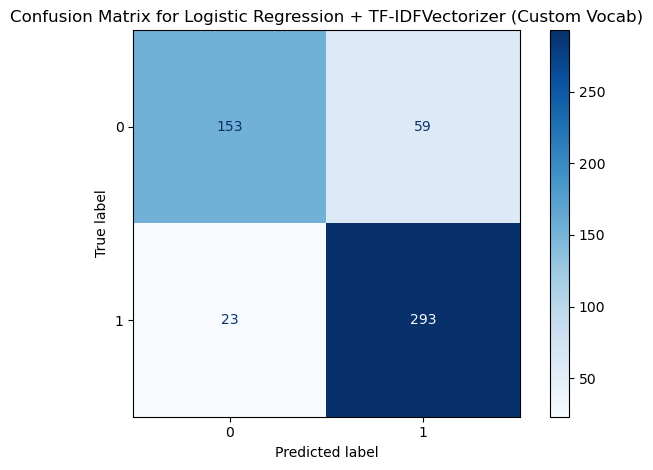

In [218]:
plot_confusion_matrix(y_test, y_pred, 'Logistic Regression + TF-IDFVectorizer (Custom Vocab)')

#### Findings 
* **Precision**: 0.70
> * There is a significant drop in accuracy from 85% in the baseline model to 70%. 
* **Recall**: 0.95
> * While the recall for r/personalfinance was 95%, the recall for r/investing was a mere 40%. This suggests that many r/investing posts are misclassified as r/personalfinance. This suggests a high number of False Negatives for r/investing which significantly decreased performance. 
* **F-1 Score**: 0.81
> * The imbalance between r/investing scores and r/personalfinance scores suggests that the model is overfitting to r/personalfinance and failing to identify r/investing correctly. 
* **Overall Accuracy**: 0.73

### Naive Bayes Model, CountVectorizer

> Naive Bayes generally works well with text data. This is seen especially when words are independent of one another because the model automatically assumes that features are not dependent. CountVectorizer captures word frequencies well for this model which contributes to the improved results. 


In [155]:
pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

In [156]:
pipe_nb_cvec_params = {
    'cvec__max_features': [1000, 1500, 2000],
    'cvec__ngram_range': [(1, 1)],
    'nb__alpha': [0.9, 1, 2, 3]  
}

In [157]:
gs_nb_cvec = GridSearchCV(pipe_nb_cvec, 
                          pipe_nb_cvec_params, 
                          cv=5, 
                          n_jobs=-1) 

In [158]:
gs_nb_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [1000, 1500, 2000],
                         'cvec__ngram_range': [(1, 1)],
                         'nb__alpha': [0.9, 1, 2, 3]})

In [210]:
print(f'Best Score: {gs_nb_cvec.best_score_}')
print()
print(f'Best params: {gs_nb_cvec.best_params_}')
print()
y_pred = gs_nb_cvec.predict(X_test)
print(classification_report(y_test, y_pred))

Best Score: 0.8516587677725118

Best params: {'cvec__max_features': 1500, 'cvec__ngram_range': (1, 1), 'nb__alpha': 2}

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       212
           1       0.87      0.88      0.88       316

    accuracy                           0.85       528
   macro avg       0.84      0.84      0.84       528
weighted avg       0.85      0.85      0.85       528



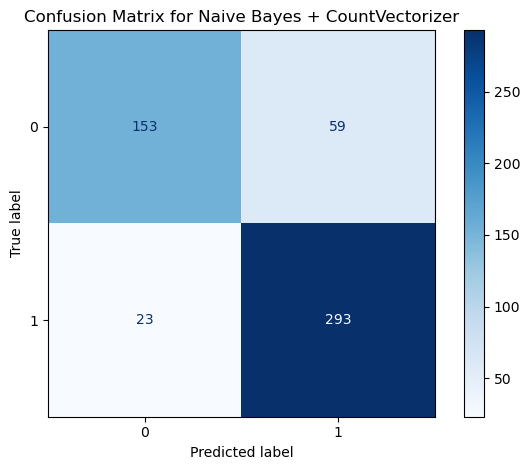

In [220]:
plot_confusion_matrix(y_test, y_pred, 'Naive Bayes + CountVectorizer')

#### Findings 
* **Precision**: 0.87
> * Naive Bayes seems to be performing on par with Logistic Regression + TfidfVectorizer. The precision for r/personalfinance is slighty higher. 
* **Recall**: 0.88
> * This means that the model identified 88% of the actual r/personalfinance posts correctly. False negatives are low because recall is high. Recall for r/investing is also higher with 81% which suggests that this model is performing better than the baseline in accurately identifying r/investing posts. Fewer false negatives are observed for r/investing as the model has improved from the baseline. 
* **F-1 Score**: 0.88
> * This is the balance between precision and recall.
* **Overall Accuracy**: 0.85

### Naive Bayes Model, TfidfVectorizer

> TF-IDF may not be able to capture word relevance as effectively for Naive Bayes in this dataset as it did for Logistic Regression. This may be due to the fact that Naive Bayes benefits more from raw frequency counts seen in CountVectorizer. 

In [148]:
pipe_nb_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

In [149]:
pipe_nb_tvec_params = {
    'tvec__max_features':[2000, 3000, 4000, 5000],
    'tvec__stop_words': [None, 'english'], 
    'tvec__ngram_range': [(1, 1), (1, 2)], 
}

In [151]:
gs_nb_tvec = GridSearchCV(pipe_nb_tvec, 
                          pipe_nb_tvec_params, 
                          cv=5, 
                          n_jobs=-1) 

In [152]:
gs_nb_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [212]:
print(f'Best Score: {gs_nb_tvec.best_score_}')
print()
print(f'Best params: {gs_nb_tvec.best_params_}')
print()
y_pred = gs_nb_tvec.predict(X_test)
print(classification_report(y_test, y_pred))

Best Score: 0.8364928909952607

Best params: {'tvec__max_features': 2000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}

              precision    recall  f1-score   support

           0       0.87      0.72      0.79       212
           1       0.83      0.93      0.88       316

    accuracy                           0.84       528
   macro avg       0.85      0.82      0.83       528
weighted avg       0.85      0.84      0.84       528



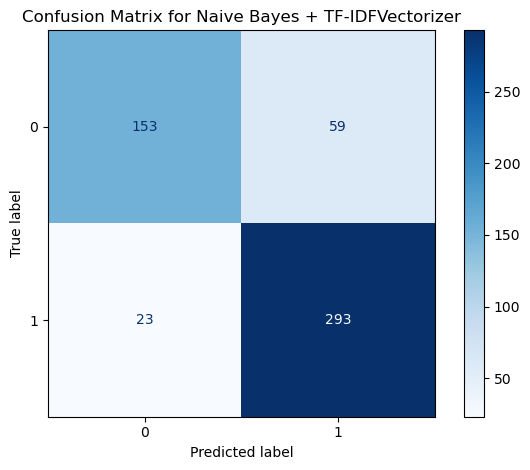

In [219]:
plot_confusion_matrix(y_test, y_pred, 'Naive Bayes + TF-IDFVectorizer')

#### Findings 
* **Precision**: 0.83
> * This means that 83% of the times the model predicted r/personalfinance, it was correct. Because precision is high, we can assume that we have low false positives. This means that the model does not incorrectly label too many r/investing posts as r/personalfinance.
* **Recall**: 0.93
> * While recall for r/personalfinance is 93% we see that recall for r/investing dropped to 72%. This means that the model faile to classify many r/investing posts. This results in a higher number of false negatives for r/investing. 
* **F-1 Score**: 0.88
> * This is the balance between precision and recall.
* **Overall Accuracy**: 0.84

In [214]:
data = {
    'Model': ['LogReg + CountVectorizer', 'LogReg + TF-IDF', 'NaiveBayes + CountVectorizer', 'NaiveBayes + TF-IDF'],
    'Precision (Class 0)': [0.82, 0.85, 0.82, 0.87],
    'Recall (Class 0)': [0.78, 0.77, 0.81, 0.72],
    'F1-Score (Class 0)': [0.80, 0.81, 0.81, 0.79],
    'Precision (Class 1)': [0.86, 0.86, 0.87, 0.83],
    'Recall (Class 1)': [0.89, 0.91, 0.88, 0.93],
    'F1-Score (Class 1)': [0.87, 0.88, 0.88, 0.88],
    'Accuracy': [0.84, 0.85, 0.85, 0.84]
}
df = pd.DataFrame(data)
df

,Model,Precision (Class 0),Recall (Class 0),F1-Score (Class 0),Precision (Class 1),Recall (Class 1),F1-Score (Class 1),Accuracy
0,LogReg + CountVectorizer,0.82,0.78,0.80,0.86,0.89,0.87,0.84
1,LogReg + TF-IDF,0.85,0.77,0.81,0.86,0.91,0.88,0.85
2,NaiveBayes + CountVectorizer,0.82,0.81,0.81,0.87,0.88,0.88,0.85
3,NaiveBayes + TF-IDF,0.87,0.72,0.79,0.83,0.93,0.88,0.84


## Conclusion 

**Key Metrics**
> * Precision: This measured how many of the posts predicted to be in a subreddit actually belonged to that subreddit. This was an important metric to note because false positives, in this case when r/investing posts are classified as r/personalfinance, are costly. This would mean the company would be marketing to professional investors when their target audience is novices.
> * Recall: This measured how many of the actual posts from a subreddit were correctly identified. Having false negatives and missing r/personalfinance posts are detrimental because the company could be missing out on potential users.
> * F1- Score: This gives an overall picture of the model's performance.

**Logistic Regression with TF-IDF**
> * Best Score: 0.848
> * Precision: 0.86
> * Recall: 0.91
> * F1-Score: 0.88
> * This model has very high recall, meaning it is able to correctly identify 91% of the posts from r/personalfinance. It also has a strong precison of 86% meaning that a high percentage of posts classified as r/personalfinance are correct.

**Naive Bayes with CountVectorizer**
> * Best Score: 0.851
> * Precision: 0.87
> * Recall: 0.88
> * F1-Score: 0.88
> * This model has a slightly lower recall for r/personalfinance (from 0.91 to 0.88). The other metrics are fairly on par with the Logistic Regression model. This means that the model is still very good but it misses a few more r/personalfinance posts compared to the logistic model.

**FP vs FN**
> * False Positives (FP): This occurs when the model is predicting a post is from r/personalfinance when it's actually from r/investing. Too many false positives could result in a company targeting users who may already be investors and would not find any benefit from the company's product.
> * False Negatives (FN): This occurs when the model is predicting a post is from r/investing when it is actually from r/personalfinance. False negatives could result in a company missing potential users who are novices and may be interested in the company's product. This may be worse for the company in the long run.

**Best Model**

#### Logistic Regression with TF-IDF!! 
This model has the highest recall for identifying posts from r/personalfinance. This means that a company that uses this model to scout for novices who are interested in investing will reach their target audience. It is the best choice because it prioritizes capturing as many r/persnalfinance posts as possible (these are potential users). 
